# Processing GEM2 and magnaprobe data

**Adam Steer**

**May 2022**

From Magnaprobe and GEM2 measurements we get snow depth at about 1-2m along track resolotion, and combined snow + ice depth at some unknown resolution.

From these datasets, we need to generate snow depth (done!), ice thickness, draft and freeboard.

For ice thickness, draft and freeboard we rely on some assumptions about hydrostatic equilibrium and density of snow and ice. Using those, we model freeboard and draft using snow depths from the magnaprobe and combined snow and ice thickness from the GEM2 as constraints.

This notebook uses the approach:

- collect drift-corrected magnaprobe data into a set of point geometries
- collect drift-corrected GEM2 data into a set of point geometries
- test each magnaprobe point and find GEM2 data within 2.5 m radius (5m diameter)
- collect the median of GEM2 points found in that radius
- subtract magnaprobe snowdepth from median of GEM2 points
- use median GEM2 data, magnaprobe snow depth, and snow/ice density observations to compute ice thickness, draft and freeboard

This will result in a lot of overlapping data - for example two consecutive magnaprobe points are very likely to have overlap in their region where GEM2 data are collected. Given that GEM2 has a footprint of approximately 4 m diamter, this simple relfects the reality of how the measurements are collected. If needed, spatial filtering can be done later.


In [1]:
## import all the things we need

import os

import numpy as np

from scipy import stats

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['font.size'] =18
inches = 2.51

from shapely import geometry

import pyproj

# array functions, used to generate moving standard deviations
import bottleneck as bn


In [2]:
# declare a function to compute freeboard
def find_fi(zi, zs, dwater, dice, dsnow):
    
    #derived by Claire Trenham, CSIRO, and Adam Steer.
    fi = (((dwater - dice) * zi) - dsnow * zs) / dwater
    
    return fi

# A stats printing function
def printstats(inputdata):
    print("number of observations: {}".format(len(inputdata)))
    print("min: {}".format(np.nanmin(inputdata)))
    print("max: {}".format(np.nanmax(inputdata)))
    print("mean: {}".format(np.nanmean(inputdata)))
    print("median: {}".format(np.nanmedian(inputdata)))
    print("standard deviation: {}".format(np.nanstd(inputdata)))
    print("skewness: {}".format(stats.skew(inputdata)))
    

In [3]:
## set some phsyical properties, these are used to compute sea ice freeboard

# density of seawater
d_water = 1027

# density of sea ice
d_ice = 915

# density of snow
d_snow = 350

### Start loading MP data

In [4]:
mp_data = pd.read_csv("/mnt/documents/Q2/AeNP4-05052021/transect/magnaprobe/MPdata-driftcorrected-datefixed.csv",
                      skiprows = 10)

In [5]:
mp_data

timestamp       easting       northing  snowdepth
0     05-05-2021T07:44:29.550000  1.098763e+06 -223244.009165   -0.00090
1     05-05-2021T07:44:35.010000  1.098763e+06 -223244.103340    1.20100
2     05-05-2021T07:54:24.850000  1.098766e+06 -223241.577097    1.20100
3     05-05-2021T07:54:25.930000  1.098766e+06 -223241.673100    1.20100
4     05-05-2021T07:54:26.980000  1.098765e+06 -223241.772951    1.20100
...                          ...           ...            ...        ...
3050  05-05-2021T09:29:01.500000  1.098766e+06 -223239.684288    0.06094
3051  05-05-2021T09:29:04.170000  1.098766e+06 -223240.490116    0.07116
3052  05-05-2021T09:29:07.340000  1.098766e+06 -223239.916672    1.20100
3053  05-05-2021T09:29:08.320000  1.098766e+06 -223239.803314    1.20100
3054  05-05-2021T09:29:09.260000  1.098766e+06 -223239.729120    1.20100

[3055 rows x 4 columns]

In [6]:
# generate a list of tuple coordinate pairs
xypairs = list(zip(mp_data["easting"].values, mp_data["northing"].values))

In [7]:
xypairs[0]

(1098762.7676874232, -223244.0091645851)

In [8]:
# make geometries from each point
mp_points = []

for pair in xypairs:
    mp_points.append(geometry.Point(pair[0], pair[1]))

In [9]:
# make buffered points, with 24 sided 'circles'

mp_buffers = []
for point in mp_points:
    mp_buffers.append(point.buffer(4, resolution=36))

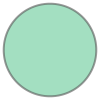

In [10]:
mp_buffers[0]

### Check distance between magnaprobe samples

get difference between array elements in X and Y coordinates, do some Pythagoras to get an idea of the magnaprobe observation step size.

This gives an approximate along-track ground sampling distance, useful for setting filtering windows later

In [11]:
stepX = np.diff(mp_data["easting"].values-5)
stepY = np.diff(mp_data["northing"].values)
mp_point2point = np.sqrt(stepX**2 + stepY**2)

In [12]:
printstats(mp_point2point)

number of observations: 3054
min: 0.0648110761615604
max: 5.058369891981802
mean: 0.9296832318106155
median: 0.8283416630844453
standard deviation: 0.41930215943114635
skewness: 1.365527121494137


## Read and geometry-ify GEM2 data

In [13]:
gem2_data = pd.read_csv("/mnt/documents/Q2/AeNP4-05052021/GEM2data-driftcorrected.csv",
                      skiprows = 10)

In [14]:
gem2_data[0:5]

time   record_id       easting       northing   xc  \
0  2021-05-05T07:48:37.539062           4  1.098779e+06 -223248.846549  0.0   
1  2021-05-05T07:48:37.640625           5  1.098779e+06 -223248.845229  0.0   
2  2021-05-05T07:48:37.742187           6  1.098779e+06 -223248.843904  0.0   
3  2021-05-05T07:48:37.835937           7  1.098779e+06 -223248.841062  0.0   
4  2021-05-05T07:48:37.937500           8  1.098779e+06 -223248.839737  0.0   

    yc  f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0  0.0         0.515          0.174           0.243           0.174   
1  0.0         0.524          0.190           0.263           0.182   
2  0.0         0.787          0.178           0.277           0.179   
3  0.0         0.447          0.183           0.285           0.170   
4  0.0         0.720          0.185           0.251           0.165   

    f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i  f18330Hz_hcp_q  \
0           0.239           0.157            0.232             nan   
1           0.228           0.158            0.232             nan   
2           0.232           0.155            0.232             nan   
3           0.235           0.155            0.233             nan   
4           0.234           0.153            0.233             nan   

    f63030Hz_hcp_i   f63030Hz_hcp_q  
0            0.197            0.115  
1            0.197            0.113  
2            0.197            0.114  
3            0.198            0.114  
4            0.198            0.117

In [15]:
gem2_data.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

### check distance between GEM2 samples

This gives an approximate along-track ground sampling distance, useful for setting filtering windows later

In [16]:
stepX = np.diff(gem2_data["easting"].values)
stepY = np.diff(gem2_data["northing"].values)

gem2_point2point = np.sqrt(stepX**2 + stepY**2)

In [17]:
printstats(gem2_point2point)

number of observations: 59203
min: 0.00023452334312915553
max: 0.33804020070769225
mean: 0.05151866690028727
median: 0.05747377355304535
standard deviation: 0.028223046488463143
skewness: 0.6703448322239316


## Check that GEM2 and Magnaprobe coordinates line up!

Here, we can add a manual XY offset (translation) to line GEM2 and magnaprobe coordinates up as closely as possible. 

Circular windows around each Magnaprobe point are also shown, to get an idea of where we will find spatially-matched data.

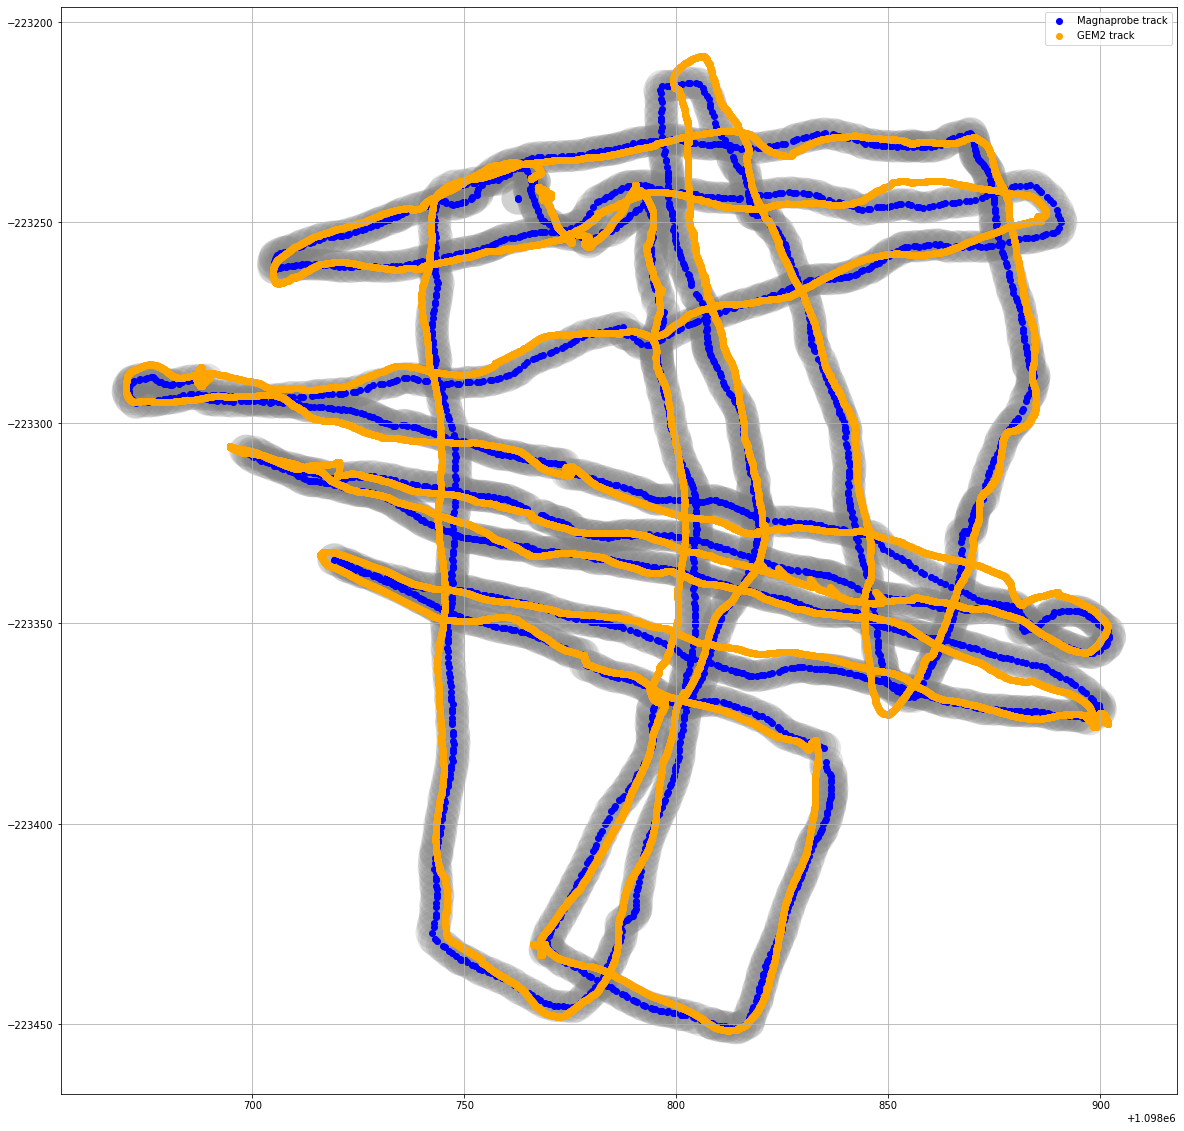

In [18]:
fig = plt.figure(figsize=(20,20))

for dot in mp_buffers:    
    xs, ys = dot.boundary.xy    
    plt.fill(xs, ys, alpha=0.2, fc='grey', ec='none')

plt.scatter(mp_data["easting"].values, mp_data["northing"].values,
            c='Blue', label = "Magnaprobe track")
plt.scatter(gem2_data["easting"].values-11.5, gem2_data["northing"].values+7,
            c = 'Orange', label = "GEM2 track")

plt.legend()
plt.grid()

Next, add the offsets we needed to align data to the data themselves...

In [19]:
# Add offsets we derived in the plot above

gem2_xypairs = list(zip(gem2_data["easting"].values-11.5, gem2_data["northing"].values+7))

In [20]:
# make geometries from each point
gem2_points = []

for pair in gem2_xypairs:
    gem2_points.append(geometry.Point(pair[0], pair[1]))

## Select GEM2 data points to use

- find GEM2 points within the buffer from MP points
- collect GEM2 observations matching those points
- compute the median of GEM2 observations
- assemble an array of MP and matching median GEM2 observations

In [21]:
mp_ind = 0
gem2_ind = 0
bufferpoints = []
collected_points = []

# iterate over MP buffers
for buffer in mp_buffers:
    #print("buffer {}".format(mp_ind))
    #then over gem2 points
    for thispoint in gem2_points:
        
        #if the buffer contains the point
        if buffer.contains(thispoint):
            
            #capture the index of each point the buffer contains
            bufferpoints.append(gem2_ind)
        
        gem2_ind += 1
    gem2_ind = 0
    collected_points.append([mp_ind, bufferpoints])
    bufferpoints = []
    mp_ind += 1

In [22]:
#see whats in the collected points array - for a non-empty point

gem2_data[" f5310Hz_hcp_i"][np.array(collected_points[4][1])]

0        0.239
1        0.228
2        0.232
3        0.235
4        0.234
         ...  
59199    0.252
59200    0.251
59201    0.249
59202    0.250
59203    0.248
Name:  f5310Hz_hcp_i, Length: 1740, dtype: float64

In [23]:
np.median(gem2_data[" f5310Hz_hcp_i"][np.array(collected_points[4][1])])

0.23

In [24]:
#generate a list of MP data indexes and GEM2 median measurements
median_gem2 = []

for datapoint in collected_points:
    if len(datapoint[1]) > 0:
        thismedian = np.median(gem2_data[" f5310Hz_hcp_i"][datapoint[1]])

    else:
        thismedian = np.nan
        
    the_array = [datapoint[0], thismedian]
    median_gem2.append(the_array)

In [25]:
# inspect the array
median_gem2[0:5]

[[0, nan], [1, nan], [2, 0.231], [3, 0.231], [4, 0.23]]

In [26]:
# this sets up an array of one GEM2 observation per Magnaprobe observation,
# using the median of GEM2 observations within some radius of the Magnaprobe observation

gem2_zi = [pair[1] for pair in median_gem2]

## Compute ice thickness, freeboard, draft

Now that we have separate ice and snow components, we can estimate freeboard and draft also!

#### Ice thickness

In [27]:
# Now, to get the ice thickness (zi) component of the GEM2 signal, we subtract the Magnaprobe observed snow depth
# ay each point
zi = gem2_zi - mp_data["snowdepth"].values

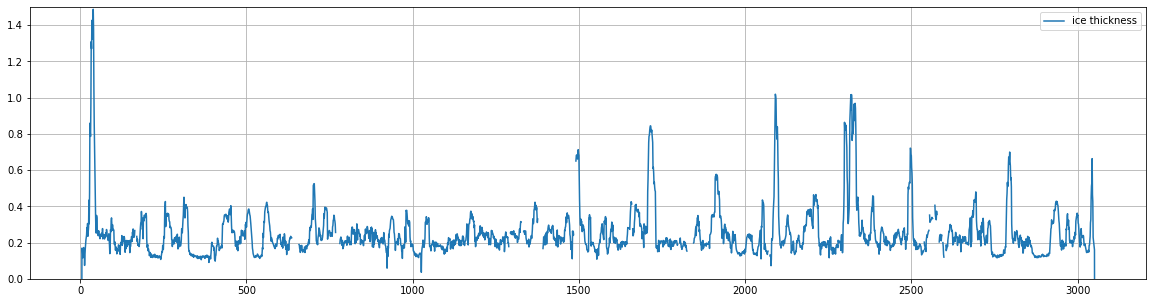

In [28]:
# quick ice thickness plot.
# note any negative values likely come from a data point in the Magnaprobe dataset which should be cleaned out 

fig = plt.figure(figsize=(20,5))

plt.plot(zi, label = "ice thickness")
plt.ylim(0, 1.5)
plt.legend()
plt.grid()

In [29]:
# show some basic stats
printstats(zi)

number of observations: 3055
min: -0.9709999999999999
max: 1.48744
mean: 0.2500897336975077
median: 0.2168
standard deviation: 0.1498838208181577
skewness: nan


#### Ice freeboard

In [30]:
# Feed ice, snow, and density numbers into our hydrostatic model to estimate sea ice freeboard
#(zi, zs, dwater, dice, dsnow)
freeboards = find_fi(zi,mp_data["snowdepth"].values, d_water, d_ice, d_snow)

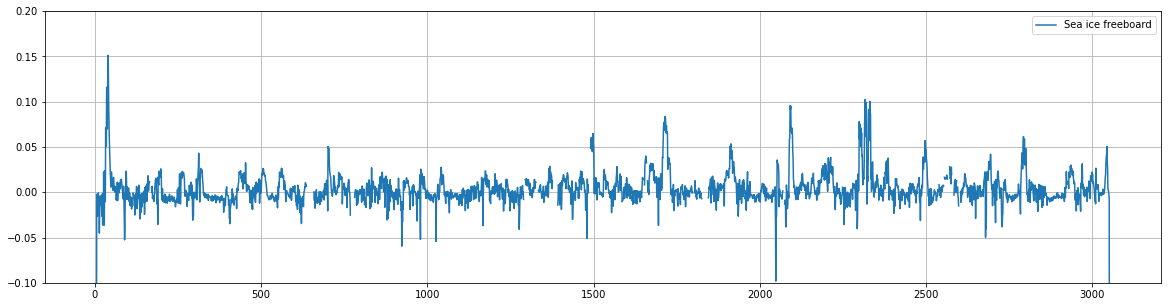

In [31]:
fig = plt.figure(figsize=(20,5))

plt.plot(freeboards, label = "Sea ice freeboard")
plt.ylim(-0.1, 0.2)
plt.legend()
plt.grid()

In [32]:
printstats(freeboards)

number of observations: 3055
min: -0.5151918208373905
max: 0.15111711781889
mean: 0.0031830662451800763
median: 0.001183252190847127
standard deviation: 0.029115263050937135
skewness: nan


#### Ice draft

In [33]:
drafts = freeboards - zi

(-1.5, 0.0)

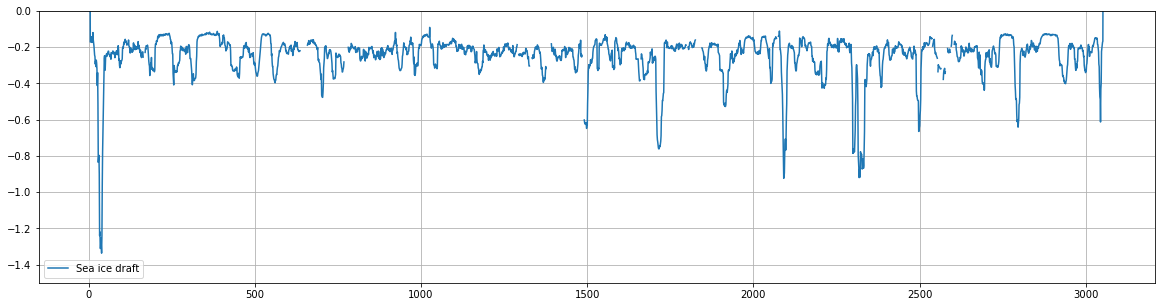

In [34]:
fig = plt.figure(figsize=(20,5))

plt.plot(drafts, label = "Sea ice draft")
plt.legend()
plt.grid()
plt.ylim(-1.5,0)

In [35]:
printstats(drafts)

number of observations: 3055
min: -1.3363228821811102
max: 0.4558081791626094
mean: -0.2469066674523276
median: -0.21709328140214215
standard deviation: 0.12856171823948187
skewness: nan


#### Sea ice surface elevation

What we see at the top - snow depth plus freeboard

In [36]:
elevation = freeboards + mp_data["snowdepth"].values

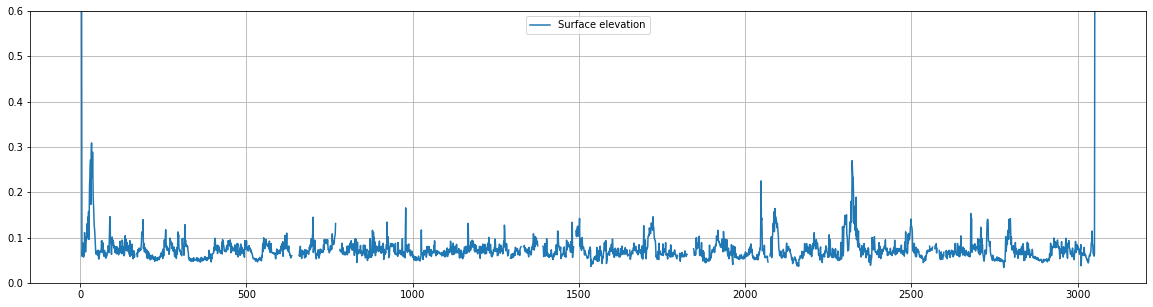

In [37]:
fig = plt.figure(figsize=(20,5))

plt.plot(elevation, label = "Surface elevation")
plt.ylim(0, 0.6)
plt.legend()
plt.grid()

In [38]:
printstats(elevation)

number of observations: 3055
min: 0.033616309639727365
max: 0.68591723466407
mean: 0.07387175521752556
median: 0.06866976630963972
standard deviation: 0.035672140196221516
skewness: nan


### Estimate surface and under-ice roughness

Collect a proxy for roughness - the standard deviation of elevation (and draft) within an approximate 5 m sliding window

In [39]:
## surface roughness. Because step size is about 0.8m, we use a window size of 6 - approx. 4.m along track

elevation_roughness = bn.move_std(elevation, window=6)


In [40]:
## draft roughness, same window size

draft_roughness = bn.move_std(drafts, window=6)

## Plot all the things together

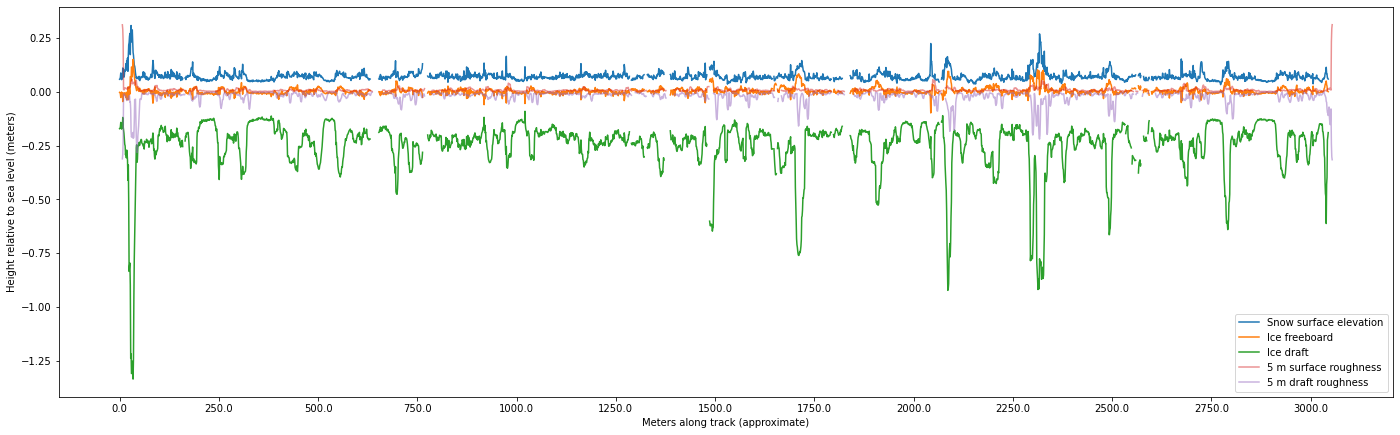

In [41]:
fig = plt.figure(figsize=(60/inches,18/inches))

plt.plot(freeboards[5:-5] + mp_data["snowdepth"].values[5:-5], label = "Snow surface elevation")
plt.plot(freeboards[5:-5], label = "Ice freeboard")
plt.plot(drafts[5:-5], label = "Ice draft")

## roughnesses are offset a little, just so they're visible
plt.plot(np.array(elevation_roughness), label = "5 m surface roughness", alpha = 0.5)

plt.plot((0-draft_roughness), label = "5 m draft roughness", alpha = 0.5)



plt.legend()
ax = plt.gca()

thenumbers = np.arange(0, len(drafts),250)
xticks_meters = [x * np.median(mp_point2point) for x in thenumbers]

plt.xticks(thenumbers,xticks_meters)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xlabel("Meters along track (approximate)")
ax.set_ylabel("Height relative to sea level (meters)")

plt.savefig("/mnt/documents/Q2/AeNP4-05052021/transect/alongtrack-snowandice.png")

## Because we all love a histogram...

...and histograms give us some information about distributions, here are a few hopefully useful ones.

In [42]:
icebins = np.arange(0, np.nanmax(zi), 0.02)
snowbins = np.arange(0, 0.5, 0.01)

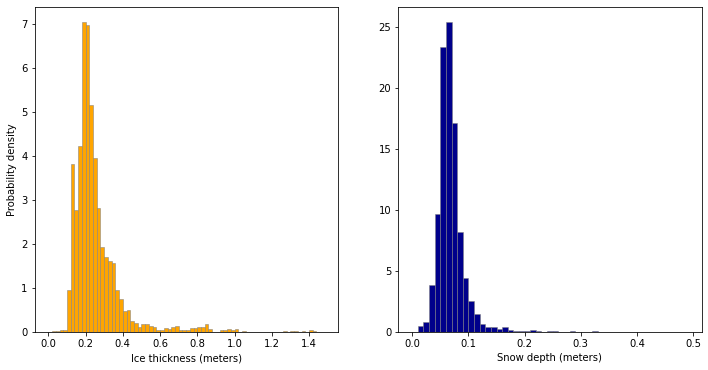

In [43]:
fig = plt.figure(figsize = (30/inches,15/inches))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(zi, icebins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'ice thickness',
                            density = True)


day1snowhist, snowx, _ = ax2.hist(mp_data["snowdepth"].values, snowbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'snow depth', density = True)


ax1.set_xlabel("Ice thickness (meters)")
ax1.set_ylabel("Probability density")
ax2.set_xlabel("Snow depth (meters)")

plt.savefig("/mnt/documents/Q2/AeNP4-05052021/transect/AeNQ2-2021-P4-zi-zs-2panelhistogram.png")

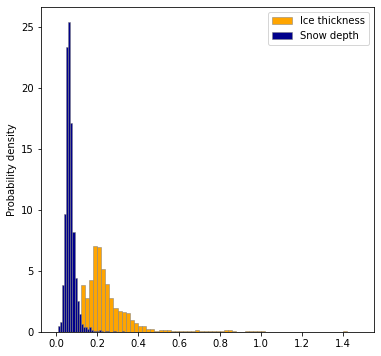

In [44]:
fig = plt.figure(figsize = (15/inches,15/inches))

ax1 = fig.add_subplot(111)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(zi, icebins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'Ice thickness',
                             density = True)


day1snowhist, snowx, _ = ax1.hist(mp_data["snowdepth"].values, snowbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'Snow depth', density = True)


#ax1.set_xlabel("GEM2 ice thickness (meters)")
ax1.set_ylabel("Probability density")
#ax2.set_xlabel("Magnaprobe snow depth (meters)")

plt.legend()

plt.savefig("/mnt/documents/Q2/AeNP4-05052021/transect/AeNQ2-2021-P4-zi-zs-onepanelhistogram.png")

In [45]:
fb_bins = np.arange(0, np.nanmax(freeboards), 0.005)
elevbins = np.arange(0, 1, 0.01)

Text(0.5, 0, 'Elevation')

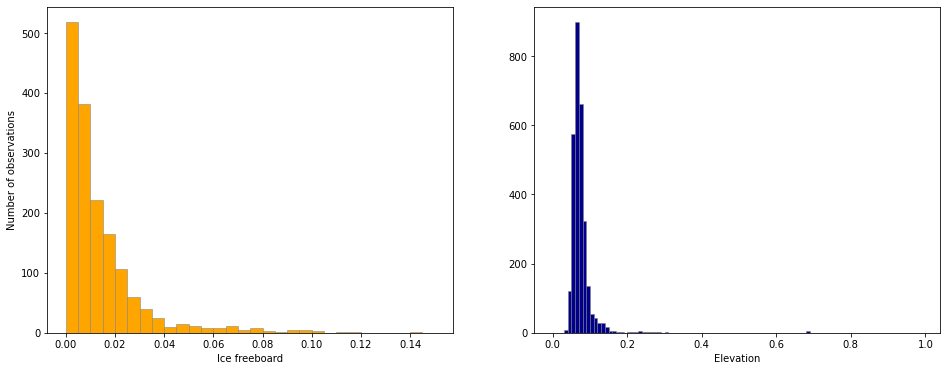

In [46]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(freeboards, fb_bins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'Freeboard')


day1snowhist, snowx, _ = ax2.hist(elevation, elevbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'Elevation')


ax1.set_xlabel("Ice freeboard")
ax1.set_ylabel("Number of observations")
ax2.set_xlabel("Elevation")

In [47]:
elev_roughness_bins = np.arange(0, np.nanmax(elevation_roughness), 0.005)
draft_roughness_bins = np.arange(0, np.nanmax(draft_roughness), 0.005)


Text(0.5, 0, 'Draft roughness')

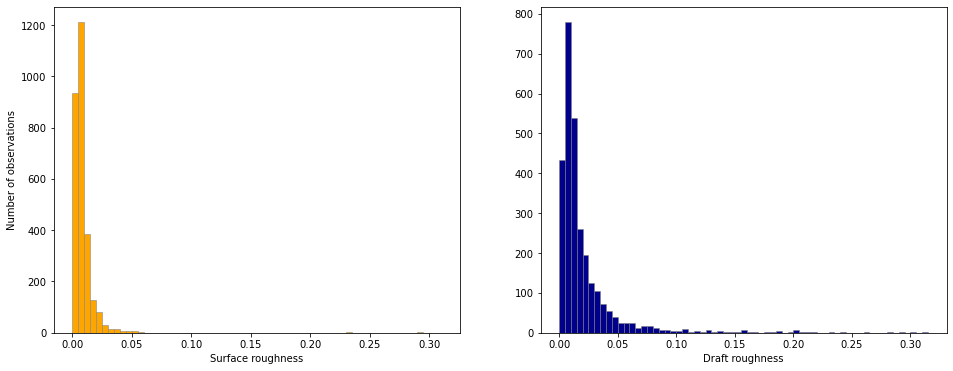

In [49]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(elevation_roughness, elev_roughness_bins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = '5 m surface roughness')


day1snowhist, snowx, _ = ax2.hist(draft_roughness, draft_roughness_bins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = '5 m draft roughness')


ax1.set_xlabel("Surface roughness")
ax1.set_ylabel("Number of observations")
ax2.set_xlabel("Draft roughness")

Text(0, 0.5, 'surface elevation')

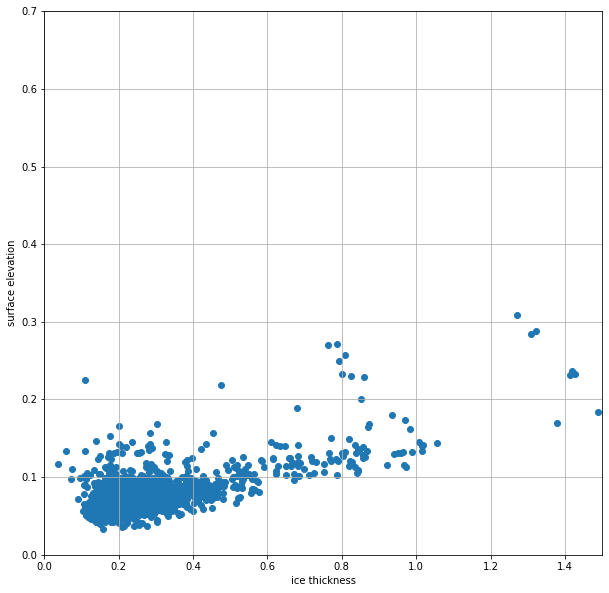

In [50]:
fig = plt.figure(figsize=(10,10))
plt.scatter(zi, elevation)
plt.xlim(0, 1.5)
plt.ylim(0,0.7)
plt.grid()
plt.xlabel("ice thickness")
plt.ylabel("surface elevation")


In [51]:
# from: https://localcoder.org/pearson-correlation-and-nan-values

bad = ~np.logical_or(np.isnan(elevation), np.isnan(zi))

elevs_for_r = np.compress(bad, elevation)
zi_for_r = np.compress(bad, zi)

In [52]:
stats.spearmanr(elevation, zi, nan_policy = "omit")

SpearmanrResult(correlation=0.4975949162336386, pvalue=4.5037469046090825e-183)

## map of ice thickness values

Visualising how many matches we got between MP and GEM2 data

In [62]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

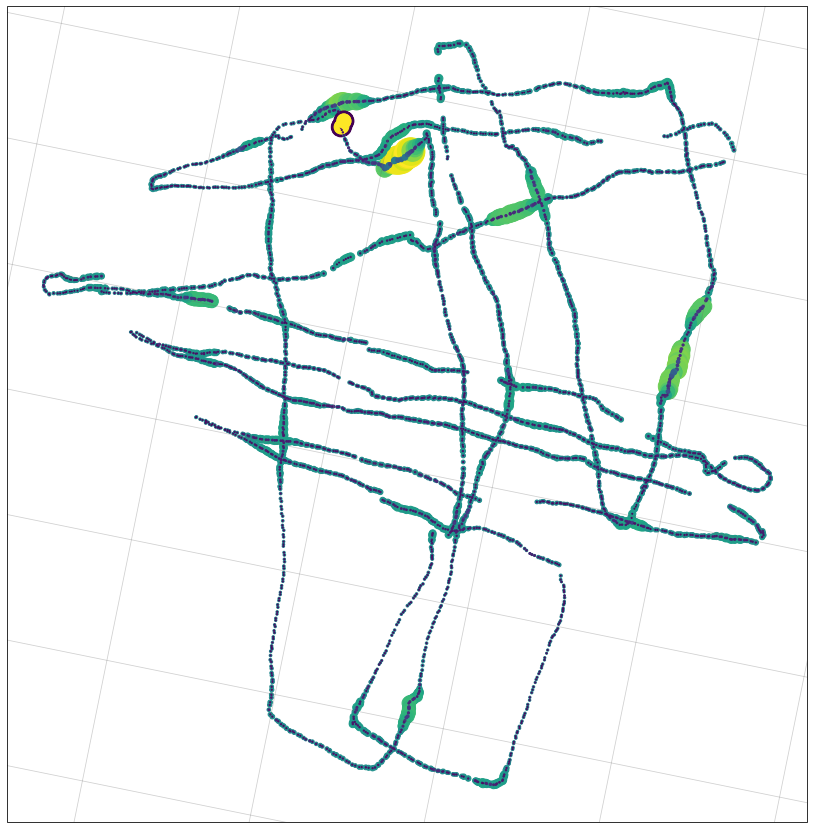

In [63]:
fig = plt.figure(figsize=(15,15))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values, mp_data["northing"].values, c=zi, s = (20*zi)**2,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness")

plt.scatter(mp_data["easting"].values, mp_data["northing"].values,
           c=elevation, s = (20*elevation)**2, cmap="viridis",
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Elevation")
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)


In [55]:
## Maybe we could filter out too-close obs here... less than 0.4 / 40 cm?

In [56]:
len(mp_data["northing"].values)

3055

In [57]:
len(mp_point2point)

3054

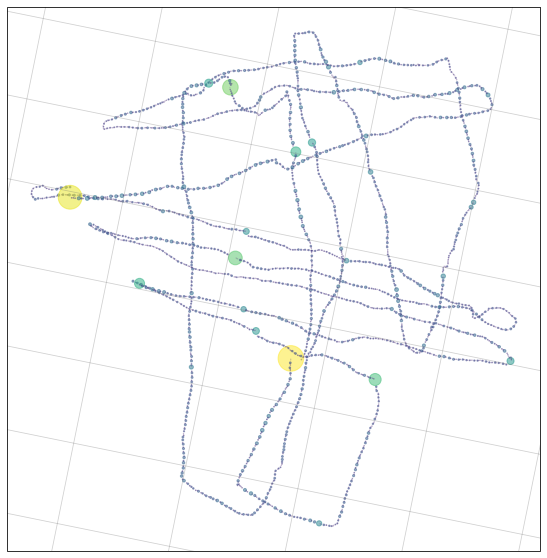

In [58]:
fig = plt.figure(figsize=(10,10))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values[1:], mp_data["northing"].values[1:], c= mp_point2point, s= mp_point2point**4, alpha=0.5,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ))
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)

In [59]:
mp_data.keys()

Index(['timestamp', 'easting', 'northing', 'snowdepth'], dtype='object')

In [60]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)
latlon = backtolatlon.transform(mp_data["easting"].values, mp_data["northing"].values)

In [61]:
len(latlon[0])

3055

In [62]:
len(drafts)

3055

In [66]:
zi_export = pd.DataFrame({"timestamp": mp_data["timestamp"].values,
                          "easting": mp_data["easting"].values,
                          "northing": mp_data["northing"].values,
                          "latitude": latlon[0],
                          "longitude": latlon[1],
                          "snowdepth": mp_data["snowdepth"].values,
                          "ice_freeboard": freeboards,
                          "ice_thickness": zi,
                          "surface_elevation": elevation,
                          "ice_draft": drafts,
                          "5m_surface_roughness": elevation_roughness,
                          "5m_draft_roughness": draft_roughness})

In [67]:
header = """
Snow depth and ice thickness data from AeN Q2, P4
5 May 2021
Adam Steer, Polona Itkin
GEM2 data processed using libraries supplied by Stefan Hendricks
Drift correction and data alignment here: https://gitlab.com/adamsteer/aen/
Units are meters
Eastings and northings are EPSG:3413, NSIDC north polar stereographic



"""

In [68]:
outputfile = "/mnt/documents/Q2/AeNP4-05052021/transect/AenQ2-P4-snowandice.csv"

In [69]:
with open(outputfile, 'w') as outfile:
    outfile.write(header)
    
zi_export.to_csv(outputfile, index=False, mode='a')

In [64]:
from scipy import stats

In [69]:
stats.spearmanr(zi[5:-5], elevation_roughness[5:-5], nan_policy="omit")

SpearmanrResult(correlation=0.39037735965645476, pvalue=1.843756747175162e-103)

Text(0, 0.5, '5m moving standard deviaton of elevation')

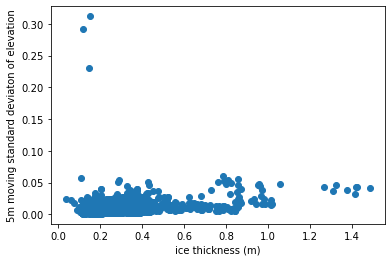

In [73]:
plt.scatter(zi[5:-5], elevation_roughness[5:-5])
plt.xlabel("ice thickness (m)")
plt.ylabel("5m moving standard deviaton of elevation")

### Comparison - main coring site stats

In [47]:
maincore = pd.read_csv("/mnt/documents/Q2/AeNP4-05052021/coring-site/Q2-P4_ICETEAM-NOTES_20210505_MM.csv", skiprows=4)

In [48]:
maincore[0:5]

Prio #core    Core name Responsoble  Ice gauge set off (cm)  \
0   2.0     1          PP        Marti                     2.5   
1   2.0     2          PP        Marti                     2.5   
2   2.0     3       P vs I       Marti                     2.5   
3   2.0     4       P vs I       Marti                     2.5   
4   1.0     5  Chemistry 1       Libby                     4.0   

   core length (cm)  ice thickness (cm)  Ice-water interface (cm)  \
0              19.5                19.5                      19.5   
1              20.5                19.5                      19.5   
2              29.5                28.5                      28.5   
3              20.0                19.5                      19.5   
4              16.0                15.0                      14.0   

   freeboard (cm) snow depth 1 (cm)  ... Section (cm)    Section horizons  \
0             0.0               5.0  ...         0-30                 0-1   
1             0.0               4.0  ...         0-30                 0-1   
2             0.0               4.0  ...          0-1                 0-1   
3             0.0               6.0  ...          0-1                 0-1   
4             1.0               6.0  ...    Full core  0-10;10-20;20-30;…   

  Pooling     FSW?/Processing  \
0     1.2                 NaN   
1     1.2                 NaN   
2     3.4                 NaN   
3     3.4                 NaN   
4    None  no, measure on ice   

                                           Parameter  \
0  primary productivity and 15N uptake, bacterial...   
1                                                NaN   
2                                       P vs I curve   
3                                                NaN   
4                 DIC/pH/Alk/dO18/nutrients/salinity   

                    Requested by                                     Remarks  \
0            Oliver, Marti, Rolf  Sectionned, sterile bagged, taken on board   
1            Oliver, Marti, Rolf  Sectionned, sterile bagged, taken on board   
2  Marti, whoever needs the rest  Sectionned, sterile bagged, taken on board   
3  Marti, whoever needs the rest  Sectionned, sterile bagged, taken on board   
4                          Libby                                  Sectionned   

  Unnamed: 20 DARK?                  comment  
0         NaN   yes  needs to be taken first  
1         NaN   yes  needs to be taken first  
2         NaN   yes  needs to be taken first  
3         NaN   yes  needs to be taken first  
4         NaN   NaN              + chemistry  

[5 rows x 23 columns]

In [49]:
maincore.keys()

Index(['Prio', '#core', 'Core name', 'Responsoble', 'Ice gauge set off (cm)',
       'core length (cm)', 'ice thickness (cm)', 'Ice-water interface (cm)',
       'freeboard (cm)', 'snow depth 1 (cm)', 'snow depth 2 (cm)',
       'snow depth 3 (cm)', 'COMMENT', 'Section (cm)', 'Section horizons',
       'Pooling', 'FSW?/Processing', 'Parameter', 'Requested by', 'Remarks',
       'Unnamed: 20', 'DARK?', 'comment'],
      dtype='object')

In [52]:
maincore_zi = []

for x in maincore["ice thickness (cm)"]:
    try:
        maincore_zi.append(float(x))
    except:
        pass
    
printstats(np.array(maincore_zi)/100)

number of observations: 54
min: 0.14
max: 0.4
mean: 0.2148809523809524
median: 0.21
standard deviation: 0.04631013587549983
skewness: nan


In [53]:
printstats(zi[5:-5])

number of observations: 3045
min: 0.035999999999999976
max: 1.48744
mean: 0.25265420403971245
median: 0.21686
standard deviation: 0.13948687849554947
skewness: nan


In [55]:
maincore_fb = []

for x in maincore["freeboard (cm)"]:
    try:
        maincore_fb.append(float(x))
    except:
        pass

printstats(np.array(maincore_fb)/100)

number of observations: 54
min: -0.02
max: 0.055
mean: 0.012261904761904762
median: 0.01
standard deviation: 0.017801898673228147
skewness: nan


In [56]:
printstats(freeboards[5:-5])

number of observations: 3045
min: -0.09812677702044789
max: 0.15111711781889
mean: 0.004252906432185167
median: 0.0012106523855891394
standard deviation: 0.017235582813208222
skewness: nan


In [57]:
snow1 = []
for x in maincore["snow depth 1 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass
    

for x in maincore["snow depth 2 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass
    
for x in maincore["snow depth 3 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass

In [60]:
printstats(np.array(snow1)/100)

number of observations: 159
min: 0.03
max: 0.08
mean: 0.05060975609756097
median: 0.05
standard deviation: 0.011920900649625229
skewness: nan


In [59]:
printstats(mp_data["snowdepth"][5:-5])

number of observations: 3045
min: 0.01045
max: 0.3231
mean: 0.06827734975369457
median: 0.0643499999999999
standard deviation: 0.02447310470621609
skewness: 2.8831274917581795
